### Grading
This week's lab doesn't have any auto-graded components. Each question in this notebook has an accompanying Peer Review question. Although the lab shows as being ungraded, you need to complete the notebook to answer the Peer Review questions. <br>
**DO NOT CHANGE VARIABLE OR METHOD SIGNATURES** 

### Validate Button
This week's lab doesn't have any auto-graded components. Each question in this notebook has an accompanying Peer Review question. Although the lab shows as being ungraded, you need to complete the notebook to answer the Peer Review questions. 

You do not need to use the Validate button for this lab since there are no auto-graded components. If you hit the Validate button, it will time out given the number of visualizations in the notebook. Cells with longer execution times cause the validate button to time out and freeze. ***This notebook's Validate button time-out does not affect the final submission grading.*** 

# Clustering RNA sequences to identify cancer types

In this assignment, we will use clustering algorithms on RNA sequence data to identify cancer types.
Since the [whole data](https://www.synapse.org/#!Synapse:syn4301332) (from [Cancer Genome Atlas Pan-Cancer project](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3919969/)) is very big, we will use a [subset data from UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#). The subset data contains only 5 labels; BRCA, KIRC, COAD, LUAD and PRAD. The meanings of those labels are as below.

|Abbreviation|Cancer|
|:----:|:-------:|
|LUSC|Lung squamous cell carcinoma |
|READ |Rectum adenocarcinoma |
|GBM |Glioblastoma multiforme|
|BLCA |Bladder Urothelial Carcinoma|
|UCEC |Uterine Corpus Endometrioid Carcinoma|
|COAD |Colon adenocarcinoma|
|OV |Ovarian serous cystadenocarcinoma|
|LAML |Acute Myeloid Leukemia|
|HNSC |Head and Neck squamous cell carcinoma|
|LUAD |Lung adenocarcinoma|
|BRCA |Breast invasive carcinoma|
|KIRC |Kidney renal clear cell carcinoma|

Although we can use the data for supervised learning model training, we will not use these labels for training, but use them for evaluation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
import time

In [2]:
# Read data. Do not change the variable names (data, label)
data = pd.read_csv('data/data.csv')
label = pd.read_csv('data/labels.csv')
data=data.drop('Unnamed: 0',axis=1)
label=label.drop('Unnamed: 0',axis=1)

### A. [Peer Review] Perform basic data inspection or EDA on the pandas dataframe.
- How many observations?
- How many features?

In [3]:
# perform basic data inspection such as getting the number of observations and number of features
data.tail()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000
800,0.0,2.325242,3.805932,6.530246,9.560367,0.0,7.957027,0.000000,0.0,0.0,...,6.403075,8.594354,10.243079,9.139459,10.102934,11.641081,10.607358,9.844794,4.550716,0.000000


In [4]:
# any missing values?
data.isnull().sum().sum()

0

In [5]:
data.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


In [6]:
label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   801 non-null    object
dtypes: object(1)
memory usage: 6.4+ KB


In [7]:
# what's the actual distribution of the class labels?
label.Class.value_counts()

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Class, dtype: int64

- Draw histograms of mean, max and min values in each feature. You may see numbers around 0-20. What do those numbers mean? (We do not expect students to know or figure out the meanings, but if you do know by chance, feel free to discuss them with the class on the discussion board.) <br>
Answer the Peer Review question about this section. 

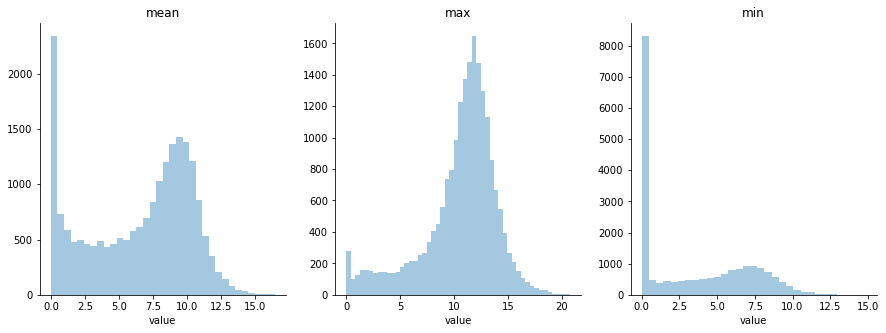

In [8]:
# draw histograms of mean, max and min values in each feature

# I like seaborn better than plain matplotlib
import seaborn as sns

# get the mean, max and min values of each feature
data_agg = data.agg(['mean', 'max', 'min'])
data_agg.reset_index(inplace=True, drop=False)
# convert into a long format
data_agg = pd.wide_to_long(data_agg, stubnames='gene_', i='index', j='feature').reset_index()
data_agg.columns = ['stat', 'gene', 'value']

stats = data_agg.stat.unique()
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, stat in enumerate(stats):
    plot_data = data_agg.loc[data_agg.stat == stat, :]
    f = sns.distplot(plot_data['value'], kde=False, ax=axs[i])
    axs[i].set_title(stat)
    sns.despine();

- If we were to train a "supervised" learning model, how would you deal with such large feature dimension? 
- Even after feature dimension reduction, still the number of useful features may be enormous. How it would impact performance or runtime of certain supervised learning algorithms? Which algorithms would suffer from high dimension features than others and why? 
- How it would impact performance or runtime of an unsupervised learning algorithm?
- Draw histograms of mean, max and min values in each feature. You may see numbers around 0-20. What those numbers mean? (We do not expect students to know or figure out the meanings, but if you do know by chance, feel free to discuss them with the class on the discussion board.) <br> <br>
Anwer these questions in this week's Peer Review assignment. 

1. If I was training a supervised model and didn't want to see what happened if I used the dataset as is, I could try using principal components analysis or something equivalent to reduce the number of dimensions and use those uncorrelated features in the model. I could also use domain knowledge or call on subject-matter experts to determine if there were a core subset of genes that could be used instead of the entire set. If all else failed, I could use try a tree-based model with heavy feature sub-sampling.

2. The higher the dimensionality of a dataset, irrespective of whether it's a large number of features, large number of cases or both, the longer any machine learning model takes to train and tune. However, some are more affected than others. Algorithms more sensitive to high feature dimensionality include:
    - k-nearest neighbours because its a lazy algorithm that calculates distances between data points so more features means an exponential increase in the number of distance calculations
    - decision tree ensembles like random forests and boosted tres because multiple trees are trained, which can be particularly computationally expensive when those trees have many branches and nodes
    - support vector machines because the optimisation problem they solve is more complex as the number of features increases
    
3. Similarly, higher dimension datasets also affect the performance and runtime of unsupervised training algorithms.

    - these algorithms often rely on performing calculations, transformations or distances between datapoints, so more datapoints means increased runtimes and memory requirements
    - sparsity also increases, which can lead to poor algorithm performance as they struggle to find meaningful patterns or clusters in the data
    
4. See above for the plots of the distribution of mean, max and min values.

### B. [Peer Review] Build a hierarchical clustering model
Let's build a model using hierarchical clustering. Hierarchical clustering module is available from `sklearn.cluster.AgglomerativeClustering`. You can choose linkage type and metric. Please check its documentation for more details.

**a) Number of clusters vs distance threshold**
Oftentimes hierarchical clustering does not need to know the number of clusters in advance. Instead, one needs to choose threshold distance/similarity to cut the dendrogram later. The AgglomerativeClustering module lets you specify either the number of clusters (n_clusters) or the threshold (distance_threshold). Based on our data, which should we choose to set to which value and why? <br> <br>
Answer this question in the Peer Review assignment. 

We should choose to set the number of clusters because we know how many we should have (5). If we didn't have the true labels and there were no pre-conceived hypotheses about the number of clusters that should be present then the distance threshold maybe a better choice.

#### b) Guess which metric?
Can you guess which metric to use (distance-based vs. similarity-based) and why? 
This question is not graded, but we encourage you to share your thoughts with the class. See the ungraded discussion prompt for this week's material. 

I think a distance-based metric as all the feature variables are numeric and the values represent the expression levels of genes, which inherently have a natural notion of distance or dissimilarity. If the underlying data was gene expression changes, then a similarity metric would be more appropriate.

#### c) Build a model
Build a model using n_clusters=5 option. Choose any metric and linkage type at first. Display the clustering result labels (you can just print out the result). Do not change the variable (model) name. Answer the question about this section in the Peer Review.

In [9]:
# build a model using n_clusters=5 option
model=None
# use the default options (linkage='ward', and metric='euclidean')
model = AgglomerativeClustering(n_clusters=5)
model.fit(data)
labels_pred = model.labels_

#### d) Label permuation
In clustering, the labels get assigned randomly, so the label numbering won't match the ground truth necessarily. Write a function below to find best matching label ordering based on the accuracy. Do not change the variable names. Answer the question about this section in the Peer Review. 

In [10]:
import itertools

def label_permute_compare(ytdf, yp, n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # generate all the possible permutations of the predicted labels
    all_permutations = list(itertools.permutations(set(yp)))
    # extract the true labels from the dataframe
    true_labels = ytdf.Class

    best_acc = 0
    best_mapping = None
    best_permutation = None

    # in each permutation
    for permutation in all_permutations:
        # pair each true label with a number 
        mapping = dict(zip(set(true_labels), permutation))
        # recode the true labels according to the mapping
        recoded_labels = [mapping[label] for label in true_labels]
        # calculate the accuracy
        acc = accuracy_score(recoded_labels, yp)

        # find the permutation/mapping with the highest accuracy score
        if acc > best_acc:
            best_acc = acc
            best_mapping = mapping
            best_permutation = permutation

    return best_permutation, best_acc

In [11]:
labelorder, acc = label_permute_compare(label, model.labels_)
print(labelorder, acc)

(3, 0, 2, 1, 4) 0.9950062421972534


#### e) Check confusion matrix
Use sklearn's confusion matrix and display the results. Answer the Peer Review question about this section.  

In [12]:
# display confusion matrix here
mapping = dict(zip(set(label.Class), labelorder))
recoded_labels = [mapping[label] for label in label.Class]

conf_mat = confusion_matrix(recoded_labels, model.labels_)
conf_mat

array([[299,   0,   0,   1,   0],
       [  0, 146,   0,   0,   0],
       [  0,   0, 136,   0,   0],
       [  2,   0,   0, 139,   0],
       [  0,   0,   0,   1,  77]])

#### f) Change linkage method and distance metric. Which ones lead the best performance? Print out the accuracy and confusion matrix for the best model.
<br> Answer the Peer Review questions about this section. 

In [34]:
# programmatically evaluate which linkage method and distance metric lead to the best performance
# distances (affinity) available are: 'euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'cityblock'
# linkages available are: 'ward', 'complete', 'average', 'single'

# generate all possible permutations of affinity and linkage (excluding ward)
linkages = ['complete', 'average', 'single']
distances = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'cityblock']
permutations = itertools.product(distances, linkages)

best_acc = 0
best_model = None
best_conf_mat = None

models = []
distances = []
linkages = []
scores = []

for permutation in permutations:
    # fit the model to each combination of distance and linkage methods
    model = AgglomerativeClustering(n_clusters=5, affinity=permutation[0], linkage=permutation[1])
    model.fit(data)
    # generate the model predictions
    labels_pred = model.labels_
    
    # find the true label permutation with the highest accuracy
    labelorder, acc = label_permute_compare(label, labels_pred)

    # generate the confusion matrix
    mapping = dict(zip(set(label.Class), labelorder))
    recoded_labels = [mapping[label] for label in label.Class]
    conf_mat = confusion_matrix(recoded_labels, labels_pred)
    
    # find the model with the best accuracy
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_conf_mat = conf_mat
    
    models.append(model)
    distances.append(model.affinity)
    linkages.append(model.linkage)
    scores.append(acc)
        
print('Best overall')
print(best_model)
print('Model accuracy: ', best_acc)
print('Model confusion matrix:')
print(best_conf_mat)

Best overall
AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=5)
Model accuracy:  0.9313358302122348
Model confusion matrix:
[[146   0   0   0   0]
 [  0 271   7  22   0]
 [  0   0  55  23   0]
 [  0   2   0 139   0]
 [  0   1   0   0 135]]


In [35]:
results = pd.DataFrame(data={'model': models, 'distance': distances, 'linkage': linkages, 'accuracy': scores})
results.sort_values('accuracy', ascending=False, inplace=True)
results

,model,distance,linkage,accuracy
0,"AgglomerativeClustering(affinity='euclidean', ...",euclidean,complete,0.931336
6,"AgglomerativeClustering(affinity='l2', compute...",l2,complete,0.931336
12,"AgglomerativeClustering(affinity='cosine', com...",cosine,complete,0.740325
15,"AgglomerativeClustering(affinity='cityblock', ...",cityblock,complete,0.722846
9,"AgglomerativeClustering(affinity='manhattan', ...",manhattan,complete,0.722846
3,"AgglomerativeClustering(affinity='l1', compute...",l1,complete,0.722846
8,"AgglomerativeClustering(affinity='l2', compute...",l2,single,0.375780
14,"AgglomerativeClustering(affinity='cosine', com...",cosine,single,0.375780
2,"AgglomerativeClustering(affinity='euclidean', ...",euclidean,single,0.375780
5,"AgglomerativeClustering(affinity='l1', compute...",l1,single,0.374532


The scikit-learn implementation has 'ward', 'complete', 'average', and 'single' as the possible linkage methods. Similarly, the distance metrics possible are 'euclidean', 'l1', 'l2', 'manhattan', 'cosine' and 'cityblock'. The 'ward' linkage method was dropped as it can only be used with euclidean distance, which was the first model tried. Apart from that, every single unique pair of linkage and distance methods were tried and the accuracy calculated to determine the best-performing model.

The best-performing models (there were two with the exact same accuracy of 0.931336 to 5 decimal places) used a complete linkage method and either a euclidean distance or l1 distance method. All the other models using complete linkage were next, but accuracy dropped to 0.72 to 0.74. Both single linkage and average linkage models performed poorly.

In a confusion matrix, the true labels are the rows and the predicted labels are the columns. Also, in this case note that the classes are in different orders; that is, class 5 in the first confusion matrix is class 3 in this confusion matrix. Either way, the main difference between this confusion matrix and the first one is that the complete linkage algorithm made many more incorrect predictions for two of the classes than the first one.

### C. What about k-means clustering?
Can we apply kmeans clustering on this data? Which clustering methods give a better performance? Is kmeans faster or slower?

In [14]:
# check how long a hierarchical clustering algorithm takes
start_time = time.time()
model = AgglomerativeClustering(n_clusters=5)
model.fit(data)
labels_pred = model.labels_

labelorder, acc = label_permute_compare(label, model.labels_)
print("Model accuracy:", round(acc, 5))
run_time = time.time() - start_time
print("Run time: ", round(run_time, 4), "seconds")

Model accuracy: 0.99501
Run time:  5.9454 seconds


In [15]:
# try to apply kmeans clustering on this data
# time kmeans to compare to hierarchical clustering 
# your code here
start_time = time.time()
model = KMeans(n_clusters=5)
model.fit(data)
labels_pred = model.labels_

labelorder, acc = label_permute_compare(label, model.labels_)
print("Model accuracy:", round(acc, 5))
run_time = time.time() - start_time
print("Run time: ", round(run_time, 4), "seconds")

Model accuracy: 0.99251
Run time:  9.1011 seconds


Yes, there is no reason why the K-Means clustering algorithm cannot be used on this data. The k-means algorithm with 5 clusters achieved an accuracy of 0.9925, which is very respectable and only slightly lower than the best performing hierarchical clustering model (0.9950). However, hierarchical clustering was faster at about 5.9 seconds compared to the 9.1 seconds the k-means model took.